In [3]:
import numpy as np
import pandas as pd
from platform import python_version

print(python_version())

3.7.1


In [4]:
class LDA():
    def __init__(self):
        self.w1 = None
        self.w0 = None
    
    def fit(self, X_train, y_train):
        data = X_train
        data['quality'] = y_train
        
        u0 = data.loc[data['quality']==0].iloc[:, :len(data.columns)-1]
        u1 = data.loc[data['quality']==1].iloc[:, :len(data.columns)-1]
        
        first_class_count = float(len(u0))
        second_class_count = float(len(u1))
        
        first_class_prob = first_class_count/len(y_train)
        second_class_prob = second_class_count/len(y_train)

        first_average = []
        second_average = []
        for column in u0:
            column = u0[column].values
            first_average.append(np.mean(column))

        for column in u1:
            column = u1[column].values
            second_average.append(np.mean(column))

        first_average = np.transpose(np.expand_dims(first_average, axis=1))
        second_average = np.transpose(np.expand_dims(second_average, axis=1))
        
        cov0 = np.cov(np.transpose(u0))
        cov1 = np.cov(np.transpose(u1))
        covariance_matrix = cov1 + cov0
        
        division = second_class_prob/first_class_prob
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        class_two = 0.5*float(np.matmul(np.matmul(second_average,inv_covariance_matrix),np.transpose(second_average)))
        class_one = 0.5*float(np.matmul(np.matmul(first_average,inv_covariance_matrix),np.transpose(first_average)))
        
        self.w0 = np.log(division) - class_two + class_one
        self.w1 = np.matmul(inv_covariance_matrix, (np.transpose(second_average)-np.transpose(first_average)))
        
    def predict(self, X_test):
        X_test = X_test.to_numpy()
        return [1 if np.dot(x,self.w1) + self.w0 > 0 else 0 for x in X_test]

0.7498432601880878
0.015151154825823888


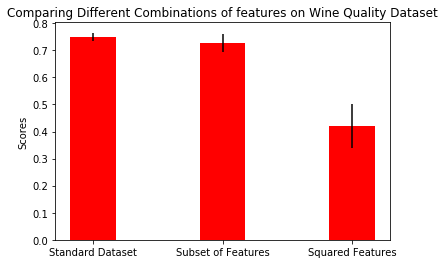

In [9]:
data = pd.read_csv("winequality-red.csv", sep=';').astype('float32')
X_train = data.iloc[:, :len(data.columns)-1]
y_train = data.iloc[:, len(data.columns)-1:].values
y_train = [0 if i < 6 else 1 for i in y_train]
data['quality'] = y_train

X_train_new = X_train.values

new_feat = []
for column in X_train_new:
    new_feat.append([x**2 for x in column])
    
X_train_new = pd.DataFrame(X_train_new)
new_feat = pd.DataFrame(new_feat)

X_train_new = pd.concat([X_train_new, new_feat], axis=1, sort=False)
data_new = X_train_new
data_new['quality'] = y_train

data_sub = data.drop(columns=['volatile acidity', 'citric acid', 'free sulfur dioxide','pH'])

def k_fold(data, n):
    results = []
    results_new = []
    fold_length = int(len(data)/5)
    for i in range(n):
        start = fold_length*i
        end = start + fold_length
        temp_data = data
        
        temp_data_test = temp_data.iloc[start:end]
        
        X_test = temp_data_test.iloc[:, :len(temp_data_test.columns)-1]
        y_test = temp_data_test.iloc[:, len(temp_data_test.columns)-1:].values
        
        top = temp_data.iloc[0:start]
        bottom = temp_data.iloc[end:len(temp_data)]
        
        temp_data_train = pd.concat([top,bottom])
        
        X_train = temp_data_test.iloc[:, :len(temp_data_train.columns)-1]
        y_train = temp_data_test.iloc[:, len(temp_data_train.columns)-1:].values
        
        lda = LDA()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)
        
        correct = 0.0
        for pred,true in zip(y_pred, y_test):
            if pred == true:
                correct += 1 
        results.append(correct/len(y_train))
        
    return results
        
results = k_fold(data, 5)
results_new = k_fold(data_sub, 5)
results_sqr = k_fold(data_new, 5)

avg = np.mean(results)
std = np.std(results)

avg_new = np.mean(results_new)
std_new = np.std(results_new)

avg_sqr = np.mean(results_sqr)
std_sqr = np.std(results_sqr)

print(avg)
print(std)

results_random = []
for i in range(5):
    y_pred = [1 if y > 0.5 else 0 for y in np.random.rand(len(y_train),1)]
    correct = 0.0
    for pred,true in zip(y_pred, y_train):
        if pred == true:
            correct += 1
    results_random.append(correct/len(y_train))

avg_ran = np.mean(results_random)
std_ran = np.std(results_random)

import matplotlib.pyplot as plt
N = 3
lda_means = (avg, avg_log, avg_ran)
lda_std = (std, std_log, std_ran)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, lda_means, width, color='r', yerr=lda_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Comparing Different Models on Wine Quality Dataset')
ax.set_xticks(ind)
ax.set_xticklabels(('LDA', 'Logistic Regression', 'Random'))

plt.show()



In [6]:
data = pd.read_csv("winequality-red.csv", sep=';').astype('float32')

In [27]:
X_train = data.iloc[:, :len(data.columns)-1]
y_train = data.iloc[:, len(data.columns)-1:].values
y_train = [0 if i < 6 else 1 for i in y_train]

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=38)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
mean = clf.score(X_test, y_test)
print(mean)



0.74375


In [38]:
u0 = data
u0 = data.loc[data['result']==0].iloc[:, :len(u0.columns)-1]

In [39]:
u1 = data
u1 = data.loc[data['result']==1].iloc[:, :len(u1.columns)-1]

In [40]:
first_class_count = float(len(u0))
second_class_count = float(len(u1))

first_class_prob = first_class_count/len(y_train)
second_class_prob = second_class_count/len(y_train)

first_average = []
second_average = []
for column in u0:
    column = u0[column].values
    first_average.append(np.mean(column))

for column in u1:
    column = u1[column].values
    second_average.append(np.mean(column))

first_average = np.transpose(np.expand_dims(first_average, axis=1))
second_average = np.transpose(np.expand_dims(second_average, axis=1))

In [41]:
# covariance_matrix_one = (1.0 / (len(y_train)-1)) * (u0 - u0.mean(axis=0)).T.dot(u0 - u0.mean(axis=0))
# covariance_matrix_two = (1.0 / (len(y_train)-1)) * (u1 - u1.mean(axis=0)).T.dot(u1 - u1.mean(axis=0))
# covariance_matrix = covariance_matrix_one + covariance_matrix_two
# covariance_matrix

cov0 = np.cov(np.transpose(u0))
cov1 = np.cov(np.transpose(u1))
covariance_matrix = cov1 + cov0

In [48]:
division = second_class_prob/first_class_prob
inv_covariance_matrix = np.linalg.inv(covariance_matrix)
class_two = 0.5*float(np.matmul(np.matmul(second_average,inv_covariance_matrix),np.transpose(second_average)))
class_one = 0.5*float(np.matmul(np.matmul(first_average,inv_covariance_matrix),np.transpose(first_average)))

NameError: name 'second_class_prob' is not defined

In [49]:
w0 = np.log(division) - class_two + class_one
w1 = np.matmul(inv_covariance_matrix, (np.transpose(second_average)-np.transpose(first_average)))

NameError: name 'division' is not defined

In [50]:
correct = 0.0
for x,y in zip(X_train.values, y_train):
    value = np.dot(x,w1) + w0
    if value > 0:
        value = 1
    else:
        value = 0
    if y == value:
        correct += 1
    
print(correct/len(y_train))

NameError: name 'w1' is not defined

In [19]:
cov0 = np.cov(np.transpose(u0))
cov1 = np.cov(np.transpose(u1))

NameError: name 'y_traincov1' is not defined

In [37]:
data = pd.read_csv("winequality-red.csv", sep=';').astype('float32')
X_train = data.iloc[:, :len(data.columns)-1]
y_train = data.iloc[:, len(data.columns)-1:].values
y_train = [0 if i < 6 else 1 for i in y_train]
data['quality'] = y_train

X_train_new = X_train.values

new_feat = []
for column in X_train_new:
    new_feat.append([x**2 for x in column])
    
X_train_new = pd.DataFrame(X_train_new)
new_feat = pd.DataFrame(new_feat)

X_train_new = pd.concat([X_train_new, new_feat], axis=1, sort=False)
X_train_new.shape

(1599, 22)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mat 
from math import exp
import Wine
import random
from scipy.special import expit

class LogisticRegression: 

    def __init__(self, data, LR, GradientDescents): 
        self.Input = data.iloc[:,:-1] #all columns except output
        self.Output = data.iloc[:,-1] #output column
        self.LR = LR #learning rate
        self.GradientDescents = GradientDescents 
        self.Weight = 0

    def sigmoid(self, prediction):
        return expit(prediction) #avoid overflow errors

    def gradientDescent(self, weights, input, output): #gradient descent

        weights = np.array(weights)
        sum = [0.0] * len(weights)
    
        for x in range(0,len(input.iloc[:,1])):
            CalculationGradient = np.multiply(input.iloc[x,:], (np.subtract(output.iloc[x], self.sigmoid(np.dot(weights.T, input.iloc[x,:])))))
            sum = np.add(sum,CalculationGradient)

        print("Sum", sum)
        weights = weights + np.multiply(self.LR, sum)
        
        
        return weights
       
    def W(self, training, resultTraining): #updates weights according to training and test set
        w = [self.Weight]
        for x in range (0,len(self.Input.columns)-1): #create array of weights
            w.append(self.Weight) 

        for y in range (0, self.GradientDescents): 
            w = self.gradientDescent(w, training, resultTraining)

        return w



    def fit(self, input, output, LR, iterations): #train using all helper methods

        weights = self.W(input, output)
        result = []

        test = 240
        for x in range(0,test):
            r = self.predict(self.Input.iloc[x,:], weights)

            if (r > 0.5):
                result.append(1)
            else:
                result.append(0)

        accuracy = self.evaluate_acc(weights, result, output)
        print("acc", accuracy)
        print("result", result) 
        print(self.Output)
        self.evaluate_acc(result, self.Output.iloc[0:x])


#feature = column 
#weight = importance
#play with weights to get bset possible

    def predict(self, features, weights):
        prediction = np.dot(features, weights)
        return self.sigmoid(prediction)



    def addInteractionTerm(self): #TASK 3

        CitricPH = []
        input = self.Input
        CitricAcid = input["citric acid"].values
        PH = input["pH"].values
        
        for x in range(0, input.shape[0]):
            interact = CitricAcid[x] * PH[x]
            CitricPH.append(interact)

        input['CitricPH'] = CitricPH

        self.input = input

    def crossValidation(self, fold):
       
        rows = len(self.Input.iloc[:,1]) #total rows 
        Division = int(rows/fold) #depending on folds
        FinalWeights = []
        AccuracyArray = []

        for x in range (0, rows, Division):
            trainingSet = self.Input.drop(self.Input.index[x:x+Division]) #training set, varies according to fold 
            resultTraining = self.Output.drop(self.Output.index[x:x+Division])

            print("Trainset", trainingSet.shape[0])
            print("resultset", resultTraining.shape[0])
            testSetInput = self.Input.iloc[x:x+Division] #held out test set
            testSetOutput = self.Output.iloc[x:x+Division]

            print("testSetIn", testSetInput.shape[0])
            print("testsetOut", testSetOutput.shape[0])
            w = self.W(trainingSet, resultTraining) #use training set to get weights
            
            accuracy = self.evaluate_acc(w, testSetInput, testSetOutput) #use weights to get prediction

            FinalWeights.append(w)
            AccuracyArray.append(accuracy)


        print("weights",  FinalWeights)
        print("array", AccuracyArray)
        sum = 0
        for x in (0,len(AccuracyArray)-1):  
            sum += x

        print ("average: ", sum/5)

        


    def evaluate_acc(self, w, input, output):
        correct = 0
        for x in range(0, len(input.iloc[:,1])):
            result = 0
            r = []
            prediction = self.predict(input.iloc[x,:], w)
            if (prediction > 0.5):
                result = 1
            else:
                result = 0
            if (result == output.iloc[x]):
                print("p", result)
                print("p2", output.iloc[x])
                correct += 1

        print("correct", correct)
        print("len input", len(input.iloc[:,1]))
        return correct / (len(input.iloc[:,1])) * 100


class Wine:
    def wineBinary(self): #also drops all rows that contain statistical outliers according to Q1 Q3 and IQR
        data = pd.read_csv("winequality-red.csv", sep=';')
        counter = 0
        for i in data.iloc[:,-1]:
            if (float(i) > 5.0):
                data.iat[counter,-1] = 1
            else:
                data.iat[counter,-1] = 0

            counter += 1

        
        for i in range(0,len(data.columns)-1):
            counter = 0
            Q1 = data.iloc[:,i].quantile(0.25)
            Q3 = data.iloc[:,i].quantile(0.75)
            IQR = float("{0:.2f}".format(Q3-Q1))
            counter = 0
            for z in data.iloc[:,i].to_numpy():
                
                if (IQR == 0.0):
                    break
                if (z > Q3 + (1.5 * IQR) or z < Q1 - (1.5 * IQR)  ):
                    try: 
                        data.drop([counter], inplace=True)
                    except:
                        continue
                   

                counter+=1
        return data



q = Wine()
data = q.wineBinary()
print(data.shape[0])
obj = LogisticRegression(data,0.11,50)



#obj.addInteractionTerm()
#obj.fit(obj.Input, obj.Output, obj.LR, obj.GradientDescents)
obj.crossValidation(5)
#print(obj.Output.iloc[0:10])

print("line break")

ModuleNotFoundError: No module named 'Wine'

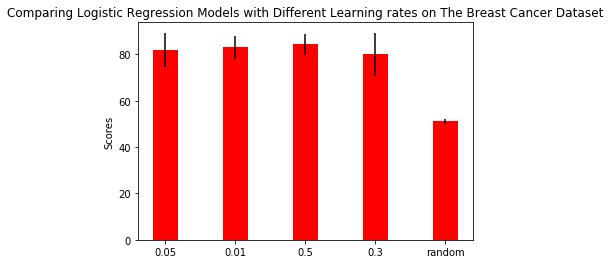

In [16]:
import matplotlib.pyplot as plt
N = 5

learn_rate_1 = [84.46601941747572, 90.29126213592234, 77.66990291262135, 87.37864077669903, 69.90291262135922]
learn_rate_2 = [85.43689320388349, 87.37864077669903, 75.72815533980582, 78.64077669902912, 88.3495145631068]
learn_rate_3 = [86.40776699029125, 87.37864077669903, 81.55339805825243, 76.69902912621359, 89.32038834951457]
learn_rate_4 = [84.46601941747572, 87.37864077669903, 79.6116504854369, 86.40776699029125, 62.13592233009708]

avg_1 = np.mean(learn_rate_1)
avg_2 = np.mean(learn_rate_2)
avg_3 = np.mean(learn_rate_3)
avg_4 = np.mean(learn_rate_4)

std_1 = np.std(learn_rate_1)
std_2 = np.std(learn_rate_2)
std_3 = np.std(learn_rate_3)
std_4 = np.std(learn_rate_4)

lda_means = (avg_1, avg_2, avg_3, avg_4, avg_ran*100)
lda_std = (std_1, std_2, std_3, std_4, std_ran*100)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, lda_means, width, color='r', yerr=lda_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Comparing Logistic Regression Models with Different Learning rates on The Brea Dataset')
ax.set_xticks(ind)
ax.set_xticklabels(('0.05', '0.01', '0.5', '0.3', 'random'))

plt.show()

Removing rows containing non-numerical or empty values...
Converting to int, replacing last column with binary values...
Removing outliers from the dataset...
Replacing last column with binary values...
Removing outliers from the dataset...


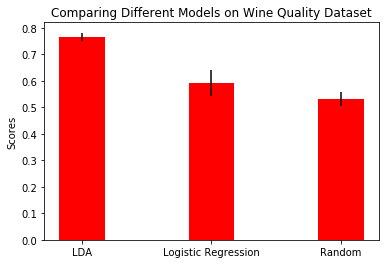

In [30]:
import numpy as np
import pandas as pd

import DataPreprocessCancer as dpc
import DataPreprocessWine as dpw
import LinearDiscriminantAnalysis as lda
from Logistic import LogisticRegression

CANCER_DATA_DIR = 'breast-cancer-wisconsin.data'
WINE_DATA_DIR = 'winequality-red.csv'

cancer_matrix = np.loadtxt(open(CANCER_DATA_DIR, "rb"), dtype='str', delimiter=",")

cancer_df = pd.DataFrame(cancer_matrix)
pre_shape = cancer_df.shape
print("Removing rows containing non-numerical or empty values...")
cancer_df = dpc.cleanValues(cancer_df)
print("Converting to int, replacing last column with binary values...")
cancer_df = dpc.strToInt(cancer_df)
cancer_df = dpc.replaceBinaryValues(cancer_df)
print("Removing outliers from the dataset...")
cancer_df = dpc.removeOutliers(cancer_df)

wine_df = pd.read_csv(WINE_DATA_DIR, sep=';')
pre_shape = wine_df.shape
print("Replacing last column with binary values...")
wine_df = dpw.wineBinary(wine_df)
print("Removing outliers from the dataset...")
wine_df = dpw.removeOutliers(wine_df)


# cancer_lda = k_fold(cancer_df, 5)
# cancer_log = [0.8640776699029125, 0.8737864077669903, 0.8155339805825243, 0.7669902912621359, 0.8932038834951457]
# cancer_ran = []
# for i in range(5):
#     y_pred = [1 if y > 0.5 else 0 for y in np.random.rand(len(cancer_df),1)]
#     correct = 0.0
#     for pred,true in zip(y_pred, y_train):
#         if pred == true:
#             correct += 1
#     cancer_ran.append(correct/len(cancer_df))

wine_lda = k_fold(wine_df, 5)
wine_log = [0.5791666666666667, 0.5791666666666667, 0.5625, 0.6416666666666667, 0.5166666666666667, 0.6666666666666666]
wine_ran = []
for i in range(5):
    y_pred = [1 if y > 0.5 else 0 for y in np.random.rand(len(cancer_df),1)]
    correct = 0.0
    for pred,true in zip(y_pred, y_train):
        if pred == true:
            correct += 1
    wine_ran.append(correct/len(cancer_df))

avg_cancer_lda = np.mean(wine_lda)
avg_cancer_log = np.mean(wine_log)
avg_cancer_ran = np.mean(wine_ran)

std_cancer_lda = np.std(wine_lda)
std_cancer_log = np.std(wine_log)
std_cancer_ran = np.std(wine_ran)

import matplotlib.pyplot as plt
N = 3
lda_means = (avg_cancer_lda, avg_cancer_log, avg_cancer_ran)
lda_std = (std_cancer_lda, std_cancer_log, std_cancer_ran)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, lda_means, width, color='r', yerr=lda_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Comparing Different Models on Wine Quality Dataset')
ax.set_xticks(ind)
ax.set_xticklabels(('LDA', 'Logistic Regression', 'Random'))

plt.show()